In [1]:
import tensorflow as tf

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
DenseNet201 = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape = (img_rows, img_cols, 3))
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in DenseNet201.layers:
    layer.trainable = False

In [2]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import batch_normalization
from keras.models import Model

# Set our class number to 4
num_classes = 2

FC_Head = lw(DenseNet201, num_classes)

model = Model(inputs = DenseNet201.input, outputs = FC_Head)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv4_block38_concat (Concatena (None, 14, 14, 1472) 0           conv4_block37_concat[0][0]       
                                                                 conv4_block38_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block39_0_bn (BatchNormal (None, 14, 14, 1472) 5888        conv4_block38_concat[0][0]       
__________________________________________________________________________________________________
conv4_block39_0_relu (Activatio (None, 14, 14, 1472) 0           conv4_block39_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block39_1_conv (Conv2D)   (None, 14, 14, 128)  188416      conv4_block39_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block39_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block39_1_conv[0][0]       
__________

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Dataset/TrainImages/'
validation_data_dir = 'Dataset/TestImages/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 528 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [6]:
from keras.optimizer_v2 import rmsprop, adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("X-Ray_Images.h5",
                             monitor="val_loss",
                             save_best_only = True,
                             verbose=1,
                             mode = 'auto',
                             save_freq = 'epoch')

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 7,
                          verbose = 1,
                          mode = 'auto')

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]
# callbacks = [checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# model.compile(loss = 'categorical_crossentropy',
#               optimizer = SGD(lr=0.01),
#               metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 528
nb_validation_samples = 120

# We only train 5 EPOCHS 
epochs = 50
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
#     steps_per_epoch = 11,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
#     validation_steps=2
)

Epoch 1/50
16/16 [==============================] - 115s 5s/step - loss: 0.4126 - accuracy: 0.8508 - val_loss: 0.1393 - val_accuracy: 0.9375

Epoch 00001: val_loss improved from inf to 0.13933, saving model to X-Ray_Images.h5
Epoch 2/50
16/16 [==============================] - 51s 3s/step - loss: 0.0782 - accuracy: 0.9718 - val_loss: 0.1975 - val_accuracy: 0.9583

Epoch 00002: val_loss did not improve from 0.13933
Epoch 3/50
16/16 [==============================] - 54s 3s/step - loss: 0.0977 - accuracy: 0.9677 - val_loss: 0.1309 - val_accuracy: 0.9583

Epoch 00003: val_loss improved from 0.13933 to 0.13090, saving model to X-Ray_Images.h5
Epoch 4/50
16/16 [==============================] - 50s 3s/step - loss: 0.0834 - accuracy: 0.9657 - val_loss: 0.1526 - val_accuracy: 0.9583

Epoch 00004: val_loss did not improve from 0.13090
Epoch 5/50
16/16 [==============================] - 47s 3s/step - loss: 0.0582 - accuracy: 0.9758 - val_loss: 0.1312 - val_accuracy: 0.9583

Epoch 00005: val_los

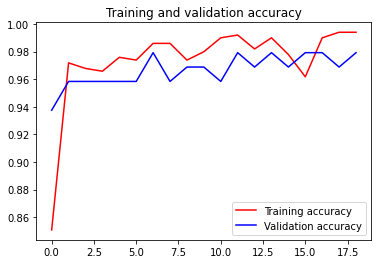

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

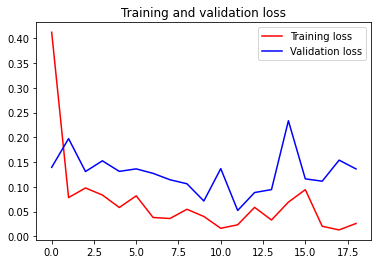

<Figure size 432x288 with 0 Axes>

In [8]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

n_covid-19-pneumonia-2.jpg
Positif Covid 19


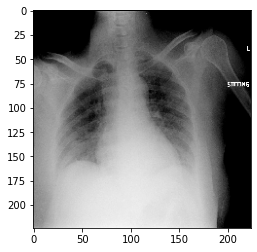

In [14]:
import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

cnn = load_model('X-Ray_Images.h5')
# change it to your filename
fn = 'n_covid-19-pneumonia-2.jpg'
 
# predicting images
path = fn
img = image.load_img(path, target_size=(224,224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) 
images = np.vstack([x])
result = cnn.predict(images)


print(fn)
if result[0][0] == 1:
  print('Positif Covid 19')
else:
  print('Negatif Covid 19')